In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('df_userratings.csv')
df.head()

,user_id,item_id,rating,timestamp
0,10001,55,5,875072688
1,10001,203,4,878542231
2,10001,183,5,875072262
3,10001,150,5,876892196
4,10001,68,4,875072688


In [2]:
df_movie=pd.read_csv('df_movies.csv')
df_movie.head()

,movie_id,movie_title,year,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye,1995,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms,1995,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty,1995,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat,1995,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


20

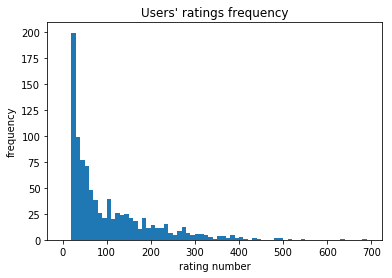

In [43]:
import numpy as np
n=df.groupby('user_id')['rating'].count();
plt.hist(n,bins=np.arange(0,700,10));
plt.title('Users\' ratings frequency')
plt.xlabel('rating number')
plt.ylabel('frequency')
min(df.groupby('user_id')['rating'].count())

Text(0, 0.5, 'number')

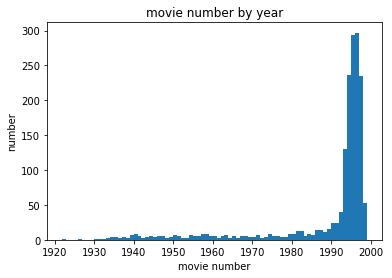

In [47]:
df_movie.year.hist(bins=np.arange(1922,2000,1),grid=False)
plt.title('movie number by year')
plt.xlabel('movie number')
plt.ylabel('number')

In [50]:
df_users=pd.read_csv('users.csv')
df_users.head()

,uid,first_name,last_name,gender,age,email,password
0,10001,Rage,GERMANO,F,34,10001@deepmovie.com,10001Rage
1,10002,Allyse,ALCID,F,23,10002@deepmovie.com,10002Allyse
2,10003,Catelyn,SATTA,M,43,10003@deepmovie.com,10003Catelyn
3,10004,Icelynn,CANOLE,M,33,10004@deepmovie.com,10004Icelynn
4,10005,Larkyn,PASSIONE,F,31,10005@deepmovie.com,10005Larkyn


In [52]:
df_url=pd.read_csv('img_url.csv')
df_url.head()

,movie_id,movie_title,img_url
0,348,Desperate Measures,https://m.media-amazon.com/images/M/MV5BMzk0Mz...
1,916,Lost in Space,https://m.media-amazon.com/images/M/MV5BMTkwNz...
2,917,Mercury Rising,https://m.media-amazon.com/images/M/MV5BODA2Nm...
3,918,City of Angels,https://m.media-amazon.com/images/M/MV5BZjk2OT...
4,1594,Everest,https://m.media-amazon.com/images/M/MV5BMTUwNz...


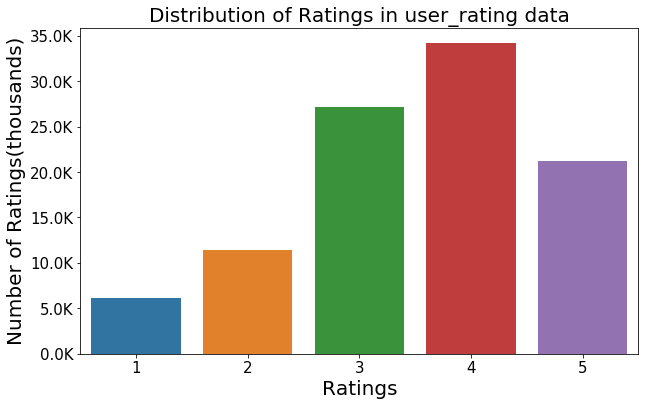

In [58]:
def changingLabels(number):
    return str(number/10**3) + "K"
plt.figure(figsize = (10, 6))
ax = sns.countplot(x="rating", data=df)

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in user_rating data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(thousands)", fontsize = 20)
plt.show()

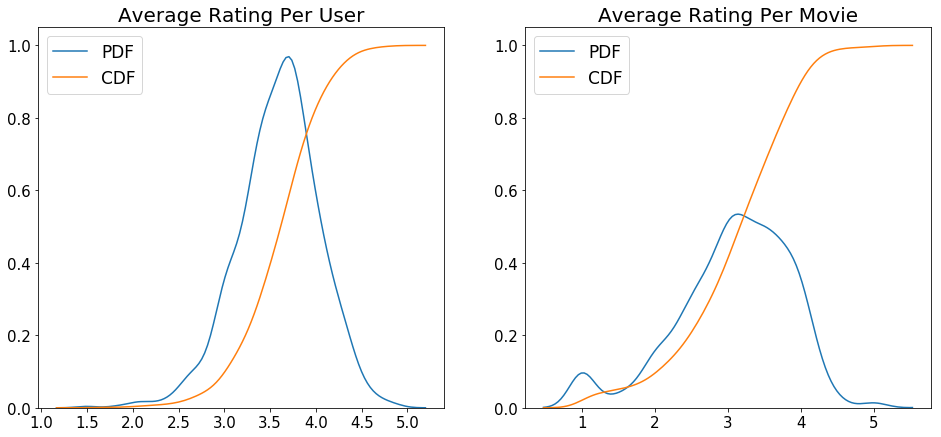

In [3]:
rating_peruser=df.groupby('user_id')['rating'].mean()
rating_peruser=list(rating_peruser)
rating_permovie=df.groupby('item_id')['rating'].mean()
rating_permovie=list(rating_permovie)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
sns.distplot(rating_peruser, hist = False, ax = axes[0], label = "PDF")
sns.kdeplot(rating_peruser, cumulative = True, ax = axes[0], label = "CDF")
axes[0].set_title("Average Rating Per User", fontsize=20)
axes[0].tick_params(labelsize = 15)
axes[0].legend(loc='upper left', fontsize = 17)

sns.distplot(rating_permovie, hist = False, ax = axes[1], label = "PDF")
sns.kdeplot(rating_permovie, cumulative = True, ax = axes[1], label = "CDF")
axes[1].set_title("Average Rating Per Movie", fontsize=20)
axes[1].tick_params(labelsize = 15)
axes[1].legend(loc='upper left', fontsize = 17)

In [8]:
from pyspark import  SparkContext
import numpy as np
# begin train model

itemRDD = sc.parallelize(np.array(df_movie).tolist())
sc = SparkContext.getOrCreate()
rawUserData=sc.parallelize(np.array(df).tolist())
header = rawUserData.first()
print(rawUserData.count()) #print the number of lines
print(rawUserData.first()) #first data(userID projectID evaluate Date)

100000
[10001, 55, 5, 875072688]


In [5]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [6]:
import time
from pyspark.mllib.recommendation import ALS
import math
############# 
rawRatings = rawUserData.map(lambda line:line[:3]) # only need three columns
ratingsRDD = rawRatings.map(lambda x:(int(x[0]),int(x[1]),int(x[2]))) # 
train, validation, test = ratingsRDD.randomSplit([6, 2, 2], seed=99)
############# 
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 1.4363302779692722
8 latent factors and regularization = 0.01: validation RMSE is 1.1443006171363697
8 latent factors and regularization = 0.05: validation RMSE is 0.9910235526924505
8 latent factors and regularization = 0.1: validation RMSE is 0.9444140419411879
8 latent factors and regularization = 0.2: validation RMSE is 0.9447917785095413
10 latent factors and regularization = 0.001: validation RMSE is 1.4618065994769907
10 latent factors and regularization = 0.01: validation RMSE is 1.1616529762635885
10 latent factors and regularization = 0.05: validation RMSE is 1.0028869259104032
10 latent factors and regularization = 0.1: validation RMSE is 0.9496430380248007
10 latent factors and regularization = 0.2: validation RMSE is 0.9502912084230765
12 latent factors and regularization = 0.001: validation RMSE is 1.5785574230200026
12 latent factors and regularization = 0.01: validation RMSE is 1.2131041109754328
12 latent 

In [9]:
import matplotlib.pyplot as plt
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        print(num_iters)
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()


1
2
3
4
5
6
7
8
9
10


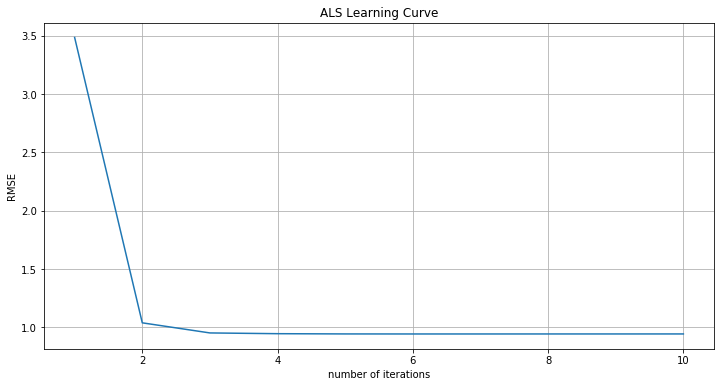

In [10]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.1, 8)

In [11]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.9471


In [12]:
############application
from pyspark.mllib.recommendation import Rating
# step1: process data
rawRatings = rawUserData.map(lambda line:line[:3])
print(rawRatings.take(5))
ratingsRDD = rawRatings.map(lambda x:(x[0],x[1],x[2])) 
print(ratingsRDD.take(5)) 
print(ratingsRDD.count()) 

# check unduplicated number of users
numUsers = ratingsRDD.map(lambda x:x[0]).distinct().count()
print(numUsers) # 943 users
# check unduplicated number of movies
numMovies = ratingsRDD.map(lambda x:x[1]).distinct().count()
print('unduplicated movie number: ',numMovies)

# step2:train model
from pyspark.mllib.recommendation import ALS
model = ALS.train(ratingsRDD,8,10,0.1) #parameter:data rank iterations reg rate
print('the model is:',model)

# step3:use model to recommend
# check the rating of recommending a movie to a user
print('the rating of recommending movie 1141 to user 10001:',model.predict(10001,1141))


# step4:display the movie title
print('the number of movies',itemRDD.count()) 
# create a dictionary of movie_id and title,key is movie_id, value is movie title
movieTitle = itemRDD.map(lambda a:(float(a[0]),a[1])).collectAsMap() 

##recommend products
recommendP = model.recommendProducts(10001,5) # the first parameter is user_id, the second is movie_id
print('For user'+str(10001)+'recommend movie\n')
for p,rec in enumerate(recommendP):
    print(str(movieTitle[rec.product])+'; recommendation rating '+'{:.3f}'.format(rec.rating)+'\n')

# recommend users
recommendU = model.recommendUsers(product=30,num=5)
print('For movie: '+str(movieTitle[rec.product])+'\n')
for i,rec in enumerate(recommendU):
    print('recommend user '+str(rec.user)+'; recommendation rating '+'{:.3f}'.format(rec.rating)+'\n')

[[10001, 55, 5], [10001, 203, 4], [10001, 183, 5], [10001, 150, 5], [10001, 68, 4]]
[(10001, 55, 5), (10001, 203, 4), (10001, 183, 5), (10001, 150, 5), (10001, 68, 4)]
100000
943
unduplicated movie number:  1682
the model is: <pyspark.mllib.recommendation.MatrixFactorizationModel object at 0x0000020983A7CA58>
the rating of recommending movie 1141 to user 10001: 3.967847708086861
the number of movies 1682
Copycat 
For user10001recommend movie

Angel Baby ; recommendation rating 5.124

Pather Panchali ; recommendation rating 4.998

Wrong Trousers, The ; recommendation rating 4.861

Saint of Fort Washington, The ; recommendation rating 4.792

Wallace & Gromit: The Best of Aardman Animation ; recommendation rating 4.784

For movie: Wallace & Gromit: The Best of Aardman Animation 

recommend user 10034; recommendation rating 5.053

recommend user 10928; recommendation rating 4.939

recommend user 10004; recommendation rating 4.859

recommend user 10310; recommendation rating 4.760

recommen